## Play around with imgaug

ref;https://github.com/aleju/imgaug

In [241]:
from imgaug import augmenters as iaa

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from skimage.transform import resize
import keras
import cv2
%matplotlib inline

import train_util
import util
import image_generator
%load_ext autoreload
%autoreload 2

image_paths = glob('./data/train/images/*.png')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
image_paths[0]

'./data/train/images/abb1521de8.png'

In [167]:
# seq = iaa.Sequential([
#     iaa.Crop(px=(0, 30)),# crop images from each side by 0 to 16px (randomly chosen)
#     iaa.Fliplr(0.5),# horizontally flip 50% of the images
# #     iaa.PiecewiseAffine((0, 0.045)),
# #     iaa.PerspectiveTransform((0, 0.125)),
#     iaa.Affine(rotate=(-10, 10), translate_percent={"x": (-.025, 0.25)}, mode='symmetric', order=1)
# ])

affine_seq = iaa.Sequential([
    # General
    iaa.SomeOf((1, 2),
               [iaa.Fliplr(0.5),
                iaa.Affine(rotate=(-10, 10),
                           translate_percent={"x": (-0.25, 0.25)}, mode='symmetric'),
                ]),
    # Deformations
    iaa.Sometimes(0.3, iaa.PiecewiseAffine(scale=(0.04, 0.08))),
    iaa.Sometimes(0.3, iaa.PerspectiveTransform(scale=(0.05, 0.1))),
], random_order=True)

seq = iaa.Sequential([affine_seq, iaa.Sometimes(0.2, iaa.Crop(px=(0, 10)))], random_order=False)

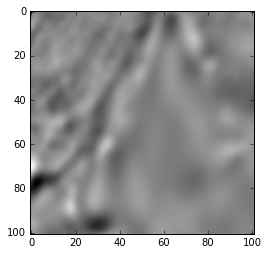

In [202]:
im_path = image_paths[2]
im_id = im_path.split('/')[-1]
im = np.expand_dims(cv2.imread(im_path), 0)
mask_path = './data/train/masks/' + im_id
mask = np.expand_dims(cv2.imread(mask_path), 0)
plt.imshow(im[0])

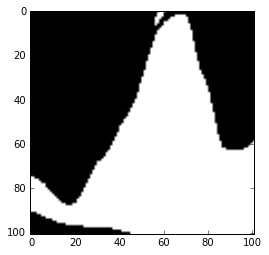

In [203]:
plt.imshow(mask[0])

In [235]:
seq_det = seq.to_deterministic()
im_aug = seq_det.augment_images(im)
mask_aug = seq_det.augment_images(mask)
mask_aug = np.array((mask_aug > 127.5), dtype='float32')

In [239]:
mask_aug.shape

(1, 101, 101, 3)

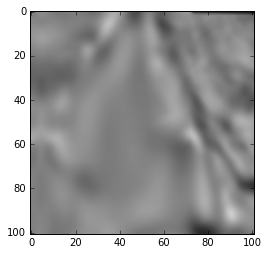

In [205]:
plt.imshow(im_aug[0])

In [206]:
# mask_aug[0]

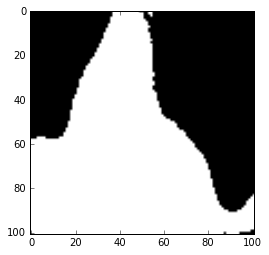

In [207]:
plt.imshow(mask_aug[0])

In [208]:
np.unique(mask_aug[0])

array([  0, 255], dtype=uint8)

In [210]:
cv2.imread(im_path).astype('float32')

array([[[124., 124., 124.],
        [130., 130., 130.],
        [135., 135., 135.],
        ...,
        [149., 149., 149.],
        [147., 147., 147.],
        [147., 147., 147.]],

       [[124., 124., 124.],
        [135., 135., 135.],
        [141., 141., 141.],
        ...,
        [147., 147., 147.],
        [147., 147., 147.],
        [147., 147., 147.]],

       [[126., 126., 126.],
        [141., 141., 141.],
        [149., 149., 149.],
        ...,
        [146., 146., 146.],
        [146., 146., 146.],
        [147., 147., 147.]],

       ...,

       [[165., 165., 165.],
        [162., 162., 162.],
        [157., 157., 157.],
        ...,
        [134., 134., 134.],
        [133., 133., 133.],
        [131., 131., 131.]],

       [[156., 156., 156.],
        [153., 153., 153.],
        [149., 149., 149.],
        ...,
        [135., 135., 135.],
        [134., 134., 134.],
        [133., 133., 133.]],

       [[146., 146., 146.],
        [144., 144., 144.],
        [141., 1

In [ ]:
##バッチ単位で同じaugされるのか、同batch内でそれぞれのimageがそれぞれのaugされるのか検証。
##それぞれの異なるaugがされるみたい　（当然か？）

In [211]:
test_flip_seq = iaa.Fliplr(0.5)

In [214]:
im_list = []
for p in image_paths[:10]:
    im_list.append(cv2.imread(p))

In [218]:
im_array = np.array(im_list)

In [219]:
test_flip_seq_det = test_flip_seq.to_deterministic()
im_aug_array = test_flip_seq_det.augment_images(im_array)

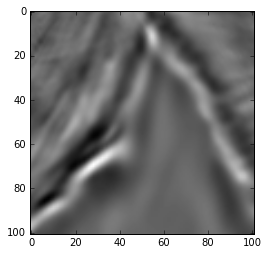

In [232]:
tgt = 5
plt.imshow(im_aug_array[tgt])

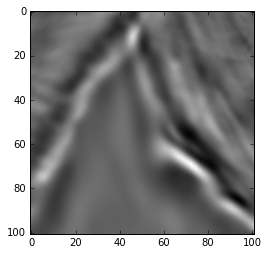

In [242]:
plt.imshow(im_array[tgt])

In [251]:
depth_prop = pd.read_csv('./data/depth_prop_cls.csv')
def get_bad_mask(im_id):
    return im_id in train_util.BAD_MASKS

In [252]:
depth_prop['bad_mask'] = depth_prop['id'].apply(get_bad_mask)

In [255]:
# depth_prop.to_csv('./data/depth_prop_cls_bad_mask.csv', index=False)

In [259]:
s = depth_prop[['id', 'z']].set_index('id')['z']
depth_dict = s.to_dict()

In [265]:
train_ids = list(depth_prop[depth_prop['data_type'] == 'train'][1000:]['id'].values)
val_ids = list(depth_prop[depth_prop['data_type'] == 'train'][:1000]['id'].values)

In [530]:
from image_generator import Generator
tgs_generator = Generator(train_ids = train_ids, depth_dict=depth_dict, val_ids=val_ids, )

In [531]:
gen = tgs_generator.generate(True)

In [532]:
b = next(gen)

In [533]:
b[2].shape

(32,)

d9e45a7fab
554


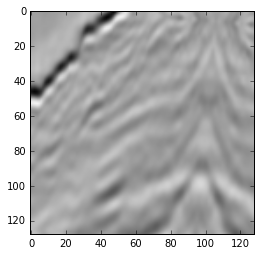

In [538]:
# tgt  = 13
tgt=5
im_id = b[2][tgt]
depth = b[0][1][tgt]
print(im_id)
print(depth)
plt.imshow(b[0][0][tgt])

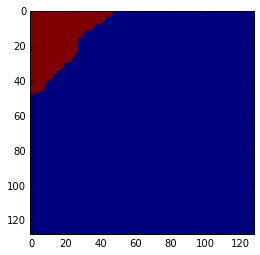

In [539]:
plt.imshow(np.squeeze(b[1][tgt]))

In [540]:
b[2][tgt]

'd9e45a7fab'

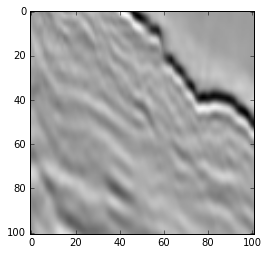

In [541]:
im = cv2.imread('./data/train/images/'+im_id + '.png')
mask = cv2.imread('./data/train/masks/'+im_id + '.png')
plt.imshow(im)

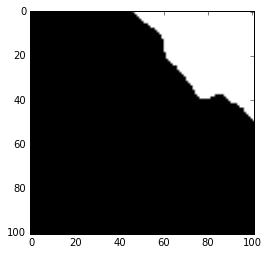

In [542]:
plt.imshow(mask)

In [500]:
np.unique(mask)

array([  0, 255], dtype=uint8)

In [462]:
mask_resize = cv2.resize(mask, (128, 128),  interpolation=cv2.INTER_NEAREST)

In [463]:
np.unique(mask_resize)

array([0], dtype=uint8)

In [464]:
np.array((mask > 127.5), dtype='float32')

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)